# Desafio 5

Neste desafio, vamos praticar sobre redução de dimensionalidade com PCA e seleção de variáveis com RFE. Utilizaremos o _data set_ [Fifa 2019](https://www.kaggle.com/karangadiya/fifa19), contendo originalmente 89 variáveis de mais de 18 mil jogadores do _game_ FIFA 2019.

> Obs.: Por favor, não modifique o nome das funções de resposta.

## _Setup_ geral

In [1]:
from math import sqrt

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sct
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats as st

from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from yellowbrick.model_selection import RFECV

from loguru import logger

In [2]:
# Algumas configurações para o matplotlib.
#%matplotlib inline

#from IPython.core.pylabtools import figsize


#figsize(12, 8)

sns.set()

In [3]:
fifa = pd.read_csv("fifa.csv")

In [4]:
columns_to_drop = ["Unnamed: 0", "ID", "Name", "Photo", "Nationality", "Flag",
                   "Club", "Club Logo", "Value", "Wage", "Special", "Preferred Foot",
                   "International Reputation", "Weak Foot", "Skill Moves", "Work Rate",
                   "Body Type", "Real Face", "Position", "Jersey Number", "Joined",
                   "Loaned From", "Contract Valid Until", "Height", "Weight", "LS",
                   "ST", "RS", "LW", "LF", "CF", "RF", "RW", "LAM", "CAM", "RAM", "LM",
                   "LCM", "CM", "RCM", "RM", "LWB", "LDM", "CDM", "RDM", "RWB", "LB", "LCB",
                   "CB", "RCB", "RB", "Release Clause"
]

try:
    fifa.drop(columns_to_drop, axis=1, inplace=True)
except KeyError:
    logger.warning(f"Columns already dropped")

## Inicia sua análise a partir daqui

In [5]:
# Sua análise começa aqui.
fifa.head()

,Age,Overall,Potential,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,31,94,94,84.0,95.0,70.0,90.0,86.0,97.0,93.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,33,94,94,84.0,94.0,89.0,81.0,87.0,88.0,81.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,26,92,93,79.0,87.0,62.0,84.0,84.0,96.0,88.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,27,91,93,17.0,13.0,21.0,50.0,13.0,18.0,21.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,27,91,92,93.0,82.0,55.0,92.0,82.0,86.0,85.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [6]:
#Quantidade de linhas e colunas
fifa.shape

(18207, 37)

In [7]:
#Dataframe auxiliar para análise dos dados
fifa_aux = pd.DataFrame({'Columns': fifa.columns,
                      'Type': fifa.dtypes,
                      'Missing': fifa.isna().sum(),
                      'Size': fifa.shape[0]
                     })
fifa_aux['Missing_%']= fifa_aux.Missing/fifa_aux.Size * 100
fifa_aux

,Columns,Type,Missing,Size,Missing_%
Age,Age,int64,0,18207,0.000000
Overall,Overall,int64,0,18207,0.000000
Potential,Potential,int64,0,18207,0.000000
Crossing,Crossing,float64,48,18207,0.263635
Finishing,Finishing,float64,48,18207,0.263635
HeadingAccuracy,HeadingAccuracy,float64,48,18207,0.263635
ShortPassing,ShortPassing,float64,48,18207,0.263635
Volleys,Volleys,float64,48,18207,0.263635
Dribbling,Dribbling,float64,48,18207,0.263635
Curve,Curve,float64,48,18207,0.263635


In [8]:
fifa_semNan = fifa.dropna()

In [9]:
fifa_semNan.shape

(18159, 37)

In [10]:
fifa_semNan.describe()

,Age,Overall,Potential,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
count,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,...,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000
mean,25.122529,66.249904,71.319126,49.734181,45.550911,52.298144,58.686712,42.909026,55.371001,47.170824,...,48.548598,58.648274,47.281623,47.697836,45.661435,16.616223,16.391596,16.232061,16.388898,16.710887
std,4.670568,6.914613,6.134420,18.364524,19.525820,17.379909,14.699495,17.694408,18.910371,18.395264,...,15.704053,11.436133,19.904397,21.664004,21.289135,17.695349,16.906900,16.502864,17.034669,17.955119
min,16.000000,46.000000,48.000000,5.000000,2.000000,4.000000,7.000000,4.000000,4.000000,6.000000,...,5.000000,3.000000,3.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,21.000000,62.000000,67.000000,38.000000,30.000000,44.000000,54.000000,30.000000,49.000000,34.000000,...,39.000000,51.000000,30.000000,27.000000,24.000000,8.000000,8.000000,8.000000,8.000000,8.000000
50%,25.000000,66.000000,71.000000,54.000000,49.000000,56.000000,62.000000,44.000000,61.000000,48.000000,...,49.000000,60.000000,53.000000,55.000000,52.000000,11.000000,11.000000,11.000000,11.000000,11.000000
75%,28.000000,71.000000,75.000000,64.000000,62.000000,64.000000,68.000000,57.000000,68.000000,62.000000,...,60.000000,67.000000,64.000000,66.000000,64.000000,14.000000,14.000000,14.000000,14.000000,14.000000
max,45.000000,94.000000,95.000000,93.000000,95.000000,94.000000,93.000000,90.000000,97.000000,94.000000,...,92.000000,96.000000,94.000000,93.000000,91.000000,90.000000,92.000000,91.000000,90.000000,94.000000


Text(0, 0.5, 'cumulative explained variance')

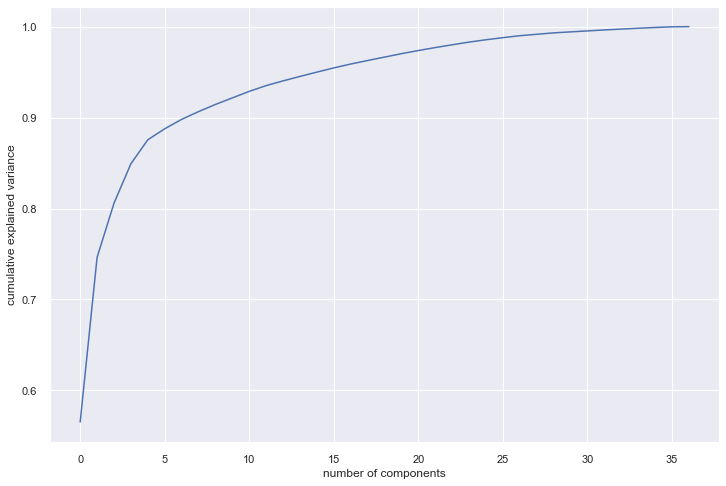

In [11]:
pca = PCA().fit(fifa_semNan)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [12]:
#Representação numérica do gráfico acima
#Com 1 componente consegue-se explicar 56% das variância total
#Com 2 componentes consegue-se explicar 74% das variância total e assim por diante
list(zip(range(1,38),np.cumsum(pca.explained_variance_ratio_)))

[(1, 0.5652805550008518),
 (2, 0.7463057741281383),
 (3, 0.8058341131991037),
 (4, 0.849261041630302),
 (5, 0.8756142741955568),
 (6, 0.8876850437426884),
 (7, 0.8980400932012534),
 (8, 0.9065696045143651),
 (9, 0.9144482343085832),
 (10, 0.9216524010776659),
 (11, 0.9288342040495106),
 (12, 0.9351631394741482),
 (13, 0.9403555623367066),
 (14, 0.9452635452700036),
 (15, 0.9500056356870821),
 (16, 0.9546333557666276),
 (17, 0.9588850882291747),
 (18, 0.9627479725467771),
 (19, 0.9665138570218944),
 (20, 0.9702647831705717),
 (21, 0.9737429352985618),
 (22, 0.977010242391492),
 (23, 0.98004162183268),
 (24, 0.9830157802817103),
 (25, 0.9855837557074095),
 (26, 0.9878872891321094),
 (27, 0.990035440452984),
 (28, 0.9915967994929686),
 (29, 0.9931503164542889),
 (30, 0.9942369587271935),
 (31, 0.9953052006126024),
 (32, 0.9963641158673704),
 (33, 0.9973222596138565),
 (34, 0.9982114690078823),
 (35, 0.9990712014375126),
 (36, 0.9998058124826665),
 (37, 1.0)]

# Utilizando dados padronizados

In [13]:
#transforma o dataframe padronizado
fifa_semNan_stand = sct.zscore(fifa_semNan)      

In [14]:
pca_norm = PCA().fit(fifa_semNan_stand)

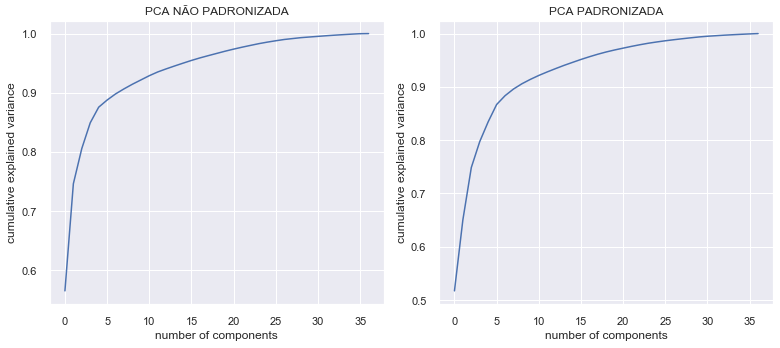

In [15]:
# PCA Padronizado e não padronizado. Verifique que existe uma diferença sutil mas existe. 
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2 , figsize=(11,5))     
ax1.plot(np.cumsum(pca.explained_variance_ratio_))
ax2.plot(np.cumsum(pca_norm.explained_variance_ratio_))
ax1.set(title='PCA NÃO PADRONIZADA', xlabel='number of components', ylabel='cumulative explained variance')   
ax2.set(title='PCA PADRONIZADA', xlabel='number of components', ylabel='cumulative explained variance') 
fig.tight_layout()

In [16]:
#Passando o n_components como um inteiro, o PCA compreende que deseja retornar somente 1 componente
#1 componente PCA consegue explicar 56% da variância total
pca = PCA(n_components = 1).fit(fifa_semNan)
pca.explained_variance_ratio_
# round(float(pca.explained_variance_ratio_),3)

array([0.56528056])

In [17]:
#Passando o n_componentes como um float, o PCA comprrende que deseja retornar as variâncias até 
#atingir o valor informado ou mais
#No exemplo abaixo ira retornar as variâncias dos componentes até atingir o 0.95 ou mais
#Somando as variancia dos 15 componentes gerados, atingirá os 0.95
pca_porc = PCA(n_components = 0.95).fit(fifa_semNan)
pca_porc.explained_variance_ratio_

array([0.56528056, 0.18102522, 0.05952834, 0.04342693, 0.02635323,
       0.01207077, 0.01035505, 0.00852951, 0.00787863, 0.00720417,
       0.0071818 , 0.00632894, 0.00519242, 0.00490798, 0.00474209])

In [18]:
len(pca_porc.explained_variance_ratio_)

15

### Considerando o grafico PCA gerado com 2 componentes
Encontrar as coordenadas do ponto X

In [19]:
pca2 = PCA(n_components=2).fit(fifa_semNan)

In [20]:
#retorna as axes da matriz rotacionada para os dois componentes gerados no PCA2
pca2.components_

array([[-6.16388751e-03, -3.70623864e-02, -2.27401748e-02,
        -2.13639023e-01, -1.98891213e-01, -1.70828950e-01,
        -1.80309140e-01, -1.87038764e-01, -2.33139606e-01,
        -2.07690956e-01, -1.84764187e-01, -1.67186902e-01,
        -2.12972623e-01, -1.38740617e-01, -1.34902279e-01,
        -1.38433521e-01, -4.91611013e-02, -1.16410947e-01,
        -1.95840156e-01, -4.07181861e-02, -1.72711671e-01,
        -2.33585866e-02, -2.16594765e-01, -1.53339724e-01,
        -1.50834334e-01, -2.24571087e-01, -1.29586783e-01,
        -1.62548283e-01, -1.01038031e-01, -1.53454113e-01,
        -1.59617493e-01, -1.47955869e-01,  2.06147192e-01,
         1.96645602e-01,  1.91129889e-01,  1.97401130e-01,
         2.08994083e-01],
       [ 8.87203494e-03,  1.58367355e-04, -7.78142440e-03,
        -4.43084573e-02, -2.57629630e-01,  1.18911964e-01,
         1.21869793e-02, -1.91182282e-01, -1.18898465e-01,
        -1.27744634e-01, -1.00178915e-01,  4.89136910e-02,
        -5.12678591e-02, -9.84

In [21]:
#para encontrar as coordenadas do ponto x neste gráfico gerado
x = [0.87747123,  -1.24990363,  -1.3191255, -36.7341814,
     -35.55091139, -37.29814417, -28.68671182, -30.90902583,
     -42.37100061, -32.17082438, -28.86315326, -22.71193348,
     -38.36945867, -20.61407566, -22.72696734, -25.50360703,
     2.16339005, -27.96657305, -33.46004736,  -5.08943224,
     -30.21994603,   3.68803348, -36.10997302, -30.86899058,
     -22.69827634, -37.95847789, -22.40090313, -30.54859849,
     -26.64827358, -19.28162344, -34.69783578, -34.6614351,
     48.38377664,  47.60840355,  45.76793876,  44.61110193,
     49.28911284
]
pca2.components_.dot(x)

array([186.55588031,  -6.59243177])

## Realizar RFE

In [22]:
fifa_semNan.head()

,Age,Overall,Potential,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,31,94,94,84.0,95.0,70.0,90.0,86.0,97.0,93.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,33,94,94,84.0,94.0,89.0,81.0,87.0,88.0,81.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,26,92,93,79.0,87.0,62.0,84.0,84.0,96.0,88.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,27,91,93,17.0,13.0,21.0,50.0,13.0,18.0,21.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,27,91,92,93.0,82.0,55.0,92.0,82.0,86.0,85.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [23]:
#target Overall
X= fifa_semNan.loc[:,fifa_semNan.columns != 'Overall']
y = fifa_semNan.Overall

In [24]:
#instancia a classe
reg = LinearRegression()

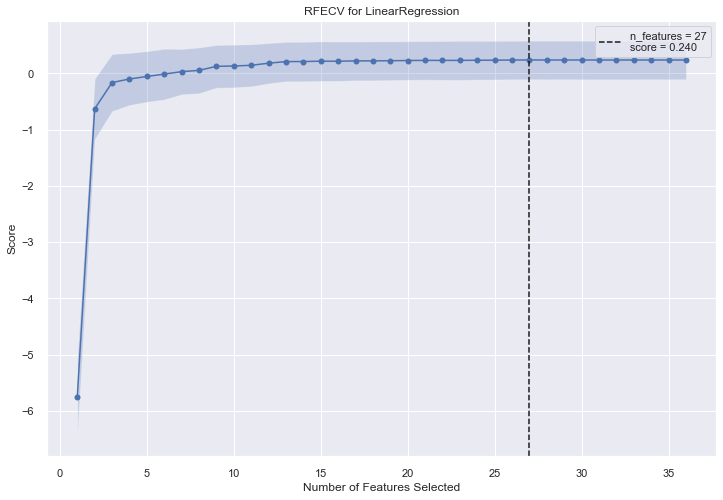

In [25]:
#Ranking das features com RFE com cross validation
#O ponto tracejado representa o score maximo com 27 features
rfecv = RFECV(reg,step=1, cv=3)
rfecv.fit(X,y)
rfecv.show()


In [26]:
#lista de features utilizadas pelo modelo
list(zip(X.columns, rfecv.support_))

[('Age', True),
 ('Potential', True),
 ('Crossing', True),
 ('Finishing', True),
 ('HeadingAccuracy', True),
 ('ShortPassing', True),
 ('Volleys', False),
 ('Dribbling', True),
 ('Curve', False),
 ('FKAccuracy', False),
 ('LongPassing', False),
 ('BallControl', True),
 ('Acceleration', True),
 ('SprintSpeed', True),
 ('Agility', False),
 ('Reactions', True),
 ('Balance', True),
 ('ShotPower', True),
 ('Jumping', False),
 ('Stamina', True),
 ('Strength', True),
 ('LongShots', False),
 ('Aggression', False),
 ('Interceptions', False),
 ('Positioning', True),
 ('Vision', True),
 ('Penalties', True),
 ('Composure', True),
 ('Marking', True),
 ('StandingTackle', True),
 ('SlidingTackle', True),
 ('GKDiving', True),
 ('GKHandling', True),
 ('GKKicking', True),
 ('GKPositioning', True),
 ('GKReflexes', True)]

In [27]:
#seleciona 5 features para o modelo utilizando somente RFE
rfe = RFE(reg, n_features_to_select=5, step=1 )
rfe = rfe.fit(X,y)

In [28]:
rfe.support_

array([ True,  True, False, False, False, False, False, False, False,
       False, False,  True, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True])

In [29]:
rfe.estimator_.coef_

array([0.63865915, 0.62543856, 0.09464924, 0.21320425, 0.06099531])

In [30]:
#lista de features utilizadas pelo modelo
#list(zip(X.columns, rfe.support_==True))
result = pd.DataFrame({
    'coluna': X.columns,
    'bool': rfe.support_})

In [31]:
result.loc[result['bool']==True, 'coluna'].tolist()

['Age', 'Potential', 'BallControl', 'Reactions', 'GKReflexes']

## Questão 1

Qual fração da variância consegue ser explicada pelo primeiro componente principal de `fifa`? Responda como um único float (entre 0 e 1) arredondado para três casas decimais.

In [ ]:
def q1():
    pca = PCA(n_components = 1).fit(fifa_semNan)
    return round(float(pca.explained_variance_ratio_),3)

## Questão 2

Quantos componentes principais precisamos para explicar 95% da variância total? Responda como un único escalar inteiro.

In [ ]:
def q2():
    pca_porc = PCA(n_components = 0.95).fit(fifa_semNan)
    pca_porc.explained_variance_ratio_
    return len(pca_porc.explained_variance_ratio_)

## Questão 3

Qual são as coordenadas (primeiro e segundo componentes principais) do ponto `x` abaixo? O vetor abaixo já está centralizado. Cuidado para __não__ centralizar o vetor novamente (por exemplo, invocando `PCA.transform()` nele). Responda como uma tupla de float arredondados para três casas decimais.

In [ ]:
x = [0.87747123,  -1.24990363,  -1.3191255, -36.7341814,
     -35.55091139, -37.29814417, -28.68671182, -30.90902583,
     -42.37100061, -32.17082438, -28.86315326, -22.71193348,
     -38.36945867, -20.61407566, -22.72696734, -25.50360703,
     2.16339005, -27.96657305, -33.46004736,  -5.08943224,
     -30.21994603,   3.68803348, -36.10997302, -30.86899058,
     -22.69827634, -37.95847789, -22.40090313, -30.54859849,
     -26.64827358, -19.28162344, -34.69783578, -34.6614351,
     48.38377664,  47.60840355,  45.76793876,  44.61110193,
     49.28911284
]

In [ ]:
def q3():
    pca2 = PCA(n_components=2).fit(fifa_semNan)
    pca2.components_.dot(x)
    return tuple(np.round(pca2.components_.dot(x),3))

## Questão 4

Realiza RFE com estimador de regressão linear para selecionar cinco variáveis, eliminando uma a uma. Quais são as variáveis selecionadas? Responda como uma lista de nomes de variáveis.

In [ ]:
def q4():
    X= fifa_semNan.loc[:,fifa_semNan.columns != 'Overall']
    y = fifa_semNan.Overall   #variavel target
    rfe = RFE(reg, n_features_to_select=5, step=1 )  #seleciona 5 variaveis
    rfe = rfe.fit(X,y)
    result = pd.DataFrame({
    'coluna': X.columns,
    'bool': rfe.support_})
    return result.loc[result['bool']==True, 'coluna'].tolist()